In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from argparse import Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from ml.models.lstm import LSTM
from ml.utils.data_utils import prepare_dataset

## Process data

In [2]:
# ───── config ─────
args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=1,
    test_size=0.2,
    ignore_cols=None,          # ← add this line
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    epochs=10,
    batch_size=64,
    lr=0.001,
    hidden_size=128,
    num_layers=2,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

## Model Train

In [3]:
# ───────────── Prepare Data ─────────────
X_train, y_train, X_test, y_test, *_ = prepare_dataset(args)
y_train_t1 = y_train[:, 0, :]               # only t+1
y_test_t1  = y_test[:, 0, :]

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                        torch.tensor(y_train_t1, dtype=torch.float32)), 
                                        batch_size=args.batch_size, shuffle=True)

In [4]:
# ───────────── Model Init ─────────────
input_dim  = X_train.shape[2]               # 6
output_dim = y_train_t1.shape[1]            # 5

model = LSTM(input_dim, args.hidden_size, args.num_layers, 0.2,
             [128, 64], output_dim,
             init_weights=True,
             matrix_rep=True,               # <<< fix
             exogenous_dim=0).to(args.device)

opt = torch.optim.Adam(model.parameters(), lr=args.lr)
crit = nn.MSELoss()

In [5]:
# ───────────── Training ─────────────
for epoch in range(args.epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(args.device), yb.to(args.device)
        opt.zero_grad()
        preds = model(xb, device=args.device)      # <<< pass device here
        loss = crit(preds, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"[{epoch+1}/{args.epochs}] Train Loss: {total_loss/len(train_loader):.4f}")

[1/10] Train Loss: 0.0172
[2/10] Train Loss: 0.0122
[3/10] Train Loss: 0.0103
[4/10] Train Loss: 0.0096
[5/10] Train Loss: 0.0093
[6/10] Train Loss: 0.0091
[7/10] Train Loss: 0.0089
[8/10] Train Loss: 0.0087
[9/10] Train Loss: 0.0086
[10/10] Train Loss: 0.0086


In [6]:
# Save model
torch.save(model.state_dict(), "base_lstm_t1.pt")

## Evaluation

In [10]:
# ─────────────────────────────────────────────
# 1) Configuration (must match training run)
args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=1,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    hidden_size=128,
    num_layers=2,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


In [11]:
# ─────────────────────────────────────────────
# 2) Load / prepare data  (skip if already in memory)
X_train, y_train, X_test, y_test, *_ = prepare_dataset(args)
y_test_t1 = y_test[:, 0, :]   # only t+1 targets

# ─────────────────────────────────────────────
# 3) Re-create the architecture  (identical to training)
input_dim  = X_train.shape[2]          # = 6 features
output_dim = len(args.targets)        # = 5 targets

In [12]:
model = LSTM(
    input_dim=input_dim,
    lstm_hidden_size=args.hidden_size,
    num_lstm_layers=args.num_layers,
    lstm_dropout=0.2,
    layer_units=[128, 64],
    num_outputs=output_dim,
    init_weights=True,
    matrix_rep=True,                  # KEEP TRUE (no reshape)
    exogenous_dim=0
).to(args.device)

In [13]:
# ─────────────────────────────────────────────
# 4) Load weights
ckpt_path = "base_lstm_t1.pt"
model.load_state_dict(torch.load(ckpt_path, map_location=args.device))
model.eval()

LSTM(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.2)
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [14]:
# ─────────────────────────────────────────────
# 5) Inference
with torch.no_grad():
    xb_test = torch.tensor(X_test, dtype=torch.float32).to(args.device)
    preds = model(xb_test, device=args.device).cpu().numpy()   # pass device!
    y_true = y_test_t1

In [16]:
# ─────────────────────────────────────────────
# 6) Metrics
print("\nEvaluation Metrics (t+1 prediction):")
for i, var in enumerate(args.targets):
    t, p = y_true[:, i], preds[:, i]
    mse  = mean_squared_error(t, p)
    rmse = mse**0.5
    mae  = mean_absolute_error(t, p)
    r2   = r2_score(t, p)
    nrmse = rmse / (t.max() - t.min())
    print(f"\n {var}")
    print(f"  MSE   : {mse:.4f}")
    print(f"  RMSE  : {rmse:.4f}")
    print(f"  MAE   : {mae:.4f}")
    print(f"  R²    : {r2:.4f}")
    print(f"  NRMSE : {nrmse:.4f}")


Evaluation Metrics (t+1 prediction):

 rnti_count
  MSE   : 0.0080
  RMSE  : 0.0896
  MAE   : 0.0660
  R²    : 0.4864
  NRMSE : 0.1253

 rb_down
  MSE   : 0.0083
  RMSE  : 0.0912
  MAE   : 0.0435
  R²    : 0.5596
  NRMSE : 0.0913

 rb_up
  MSE   : 0.0122
  RMSE  : 0.1103
  MAE   : 0.0521
  R²    : 0.6094
  NRMSE : 0.1103

 down
  MSE   : 0.0073
  RMSE  : 0.0856
  MAE   : 0.0500
  R²    : 0.4810
  NRMSE : 0.0859

 up
  MSE   : 0.0107
  RMSE  : 0.1034
  MAE   : 0.0459
  R²    : 0.5546
  NRMSE : 0.1034


## Visualization

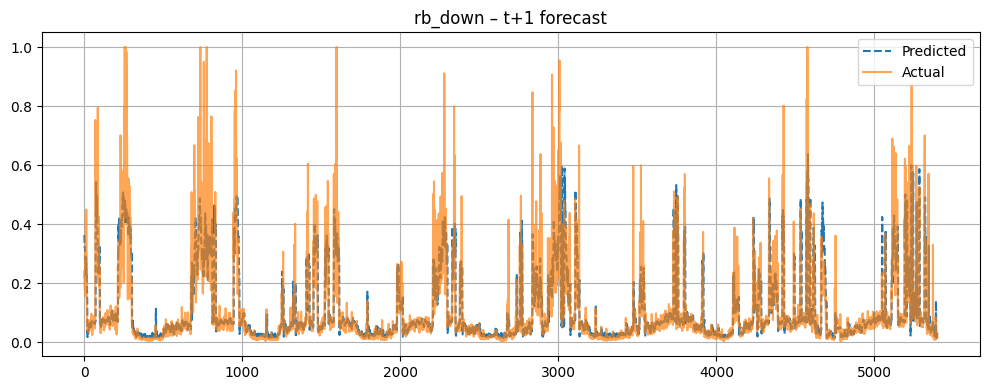

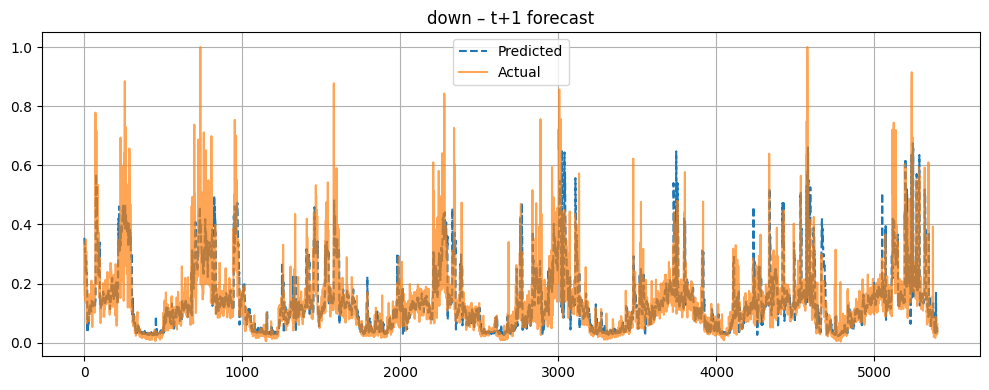

In [18]:
# ─────────────────────────────────────────────
# 7) Quick Plot for two variables (optional)
def quick_plot(preds, y_true, var):
    idx = args.targets.index(var)
    plt.figure(figsize=(10,4))
    plt.plot(preds[:, idx], '--', label='Predicted')
    plt.plot(y_true[:, idx],  label='Actual', alpha=0.7)
    plt.title(f"{var} – t+1 forecast")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

for var in ['rb_down', 'down']:
    quick_plot(preds, y_true, var)